In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from modules import UNet_conditional
from diffusion import *
from utils import *
from evaluate import *
from torch.amp import autocast
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

# Make predictions on test data

In [2]:
path = "models/test/ema_ckpt.pt"
print("Loading: ", path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = UNet_conditional(length=1024,
                         feat_num=3,
                         device=device).to(device)
ckpt = torch.load(path, map_location=device, weights_only=True)
model.load_state_dict(ckpt)

sampler = SpacedDiffusion(beta_start=1e-4,
                          beta_end=0.02,
                          noise_steps=1000,
                          section_counts=[40],
                          length=1024,
                          device=device,
                          rescale_timesteps=False)

x_real, predictions = evaluate(model,
                      sampler,
                      device,
                      "../data/test_data.csv")
x_real = np.array(x_real)
predictions = np.array(predictions)

Loading:  models/test/ema_ckpt.pt
Using device: cuda


Testing loop: 100%|███████████████████████████████████████████████| 1567/1567 [16:19<00:00,  1.60it/s]


In [3]:
mse = np.mean((x_real - predictions) ** 2)
print(f"Mean test mse error: {mse}")

Mean test mse error: 0.0010724171609633822


In [4]:
x_real

array([[0.00061579, 0.        , 0.        , ..., 0.00181409, 0.00107043,
        0.00106402],
       [0.00087057, 0.        , 0.        , ..., 0.00079498, 0.00183476,
        0.00029969],
       [0.00010624, 0.00054038, 0.        , ..., 0.        , 0.00081565,
        0.00106402],
       ...,
       [0.00112534, 0.        , 0.        , ..., 0.00054021, 0.00056087,
        0.00055447],
       [0.00087057, 0.        , 0.        , ..., 0.00155931, 0.00157998,
        0.00029969],
       [0.        , 0.        , 0.        , ..., 0.00079498, 0.0013252 ,
        0.00029969]])

In [5]:
predictions

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.37925652e-05, 9.71321017e-04, 8.18543136e-04],
       [8.63433816e-05, 0.00000000e+00, 0.00000000e+00, ...,
        2.48565804e-04, 9.15362500e-04, 2.26149708e-03],
       [4.69403341e-04, 0.00000000e+00, 0.00000000e+00, ...,
        7.81519804e-04, 3.76898795e-04, 5.92128374e-04],
       ...,
       [1.56885311e-02, 0.00000000e+00, 4.68127849e-03, ...,
        0.00000000e+00, 0.00000000e+00, 3.40810348e-03],
       [7.82532059e-03, 0.00000000e+00, 4.40302398e-03, ...,
        1.67242519e-03, 1.05849821e-02, 1.91643077e-03],
       [0.00000000e+00, 0.00000000e+00, 5.73613215e-06, ...,
        9.47502966e-04, 1.07635045e-03, 1.65822171e-03]])

# Save predictions

In [6]:
x_real_str = [','.join(map(str, row)) for row in x_real]
preds_str = [','.join(map(str, row)) for row in predictions]

df = pd.DataFrame({'x_real': x_real_str, 'predictions': preds_str})
df.to_csv('results/predictions/preds_test_0.csv', index=False)

In [7]:
df.head()

,x_real,predictions
0,"0.0006157915922813118,0.0,0.0,0.00149204465560...","0.0,0.0,0.0,0.001337653025984764,8.64558387547..."
1,"0.0008705681539140642,0.0,0.0,0.00174682121723...","8.634338155388832e-05,0.0,0.0,0.00142873625736..."
2,"0.0001062385126715526,0.0005403818213380873,0....","0.00046940334141254425,0.0,0.0,0.0018805041909..."
3,"0.0008705681539140642,3.082872717641294e-05,0....","0.0,0.005215958692133427,0.0,0.0,0.00255857408..."
4,"0.0003610150597523898,0.0,0.0,0.00123726809397...","2.0391307771205902e-05,0.0,0.00018642470240592..."


# Intro into data

In [8]:
# Find indices and values greater than 0.5
indices = np.where(np.any(x_real > 0.5, axis=1))[0]
filtered_values = [x_real[idx][x_real[idx] > 0.5] for idx in indices]
filtered_predictions = [predictions[idx][x_real[idx] > 0.5] for idx in indices]

# Flatten results and take the first 50
flat_filtered_values = np.concatenate(filtered_values)[:50]
flat_filtered_predictions = np.concatenate(filtered_predictions)[:50]

# Print the results side by side
print("Filtered Values (greater than 0.5) from x_real and corresponding Predictions:")
for value, prediction in zip(flat_filtered_values, flat_filtered_predictions):
    print(f"{value:.5f}\t\t\t{prediction:.5f}")

Filtered Values (greater than 0.5) from x_real and corresponding Predictions:
0.51206			0.48699
0.51917			0.49156
0.53315			0.50838
0.50054			0.47464
0.51451			0.47899
0.57714			0.53575
0.62085			0.57696
0.67306			0.62243
0.75889			0.69902
0.82681			0.76607
0.89323			0.82612
0.94675			0.87961
0.98621			0.91842
1.00000			0.95017
1.00000			0.93408
1.00000			0.95183
0.98376			0.92478
0.91490			0.86486
0.86643			0.82216
0.81041			0.76918
0.76278			0.72454
0.68614			0.65755
0.66184			0.63068
0.57601			0.54840
0.53988			0.51251
0.50519			0.43530
0.51203			0.43620
0.53162			0.44881
0.50025			0.41316
0.54682			0.49160
0.58773			0.53097
0.63280			0.57564
0.71023			0.64704
0.77866			0.70734
0.83973			0.76298
0.89197			0.80399
0.93576			0.84153
0.97427			0.87504
0.95795			0.85158
0.98165			0.86552
0.95217			0.83706
0.89197			0.78114
0.85242			0.74069
0.80047			0.69211
0.75615			0.64733
0.69047			0.58669
0.66184			0.56442
0.57448			0.49312
0.53402			0.45913
0.50635			0.49230


In [9]:
# Find indices where predictions > 0.8 and corresponding x_real < 0.5
indices = np.where((predictions > 0.8) & (x_real < 0.1))

# Extract filtered values from x_real and predictions
filtered_x_real = x_real[indices]
filtered_predictions = predictions[indices]

# Print the results side by side
print("Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):")
for x_val, pred_val in zip(filtered_x_real.flatten(), filtered_predictions.flatten()):
    print(f"{x_val:.5f}\t\t\t{pred_val:.5f}")

Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):
0.04902			0.85949
0.00113			0.80346


# Visualization of results

In [10]:
wavelengths = np.load('../data/wavelengths.npy')

In [11]:
wavelengths

array([ 634.835144,  635.296997,  635.758911, ..., 1123.063232,
       1123.557739, 1124.052368])

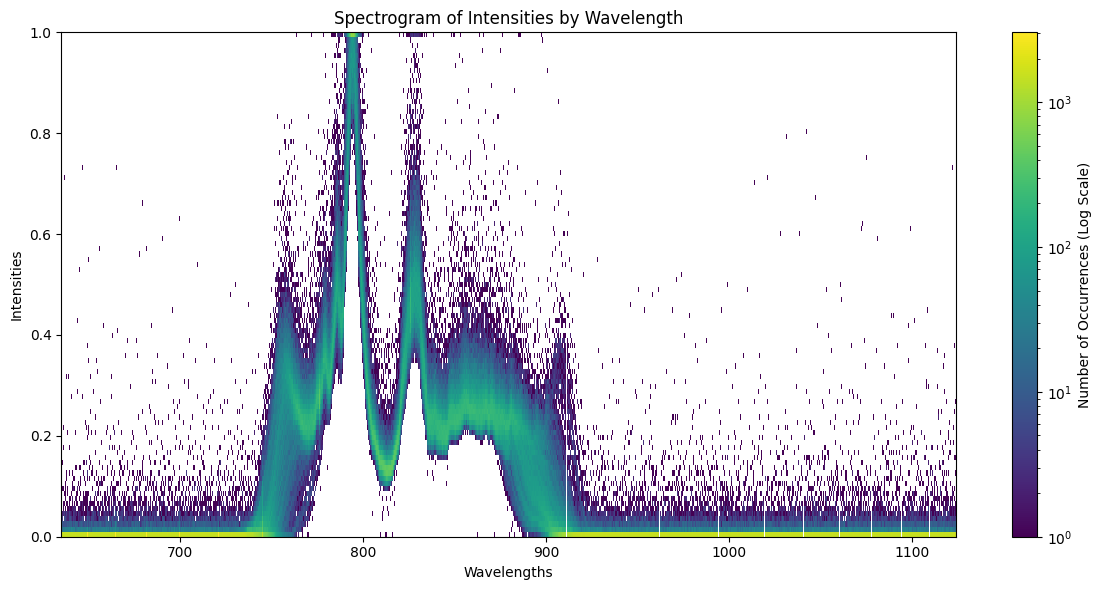

In [12]:
create_spectrogram(wavelengths, predictions, label="Spectrogram of Intensities by Wavelength")

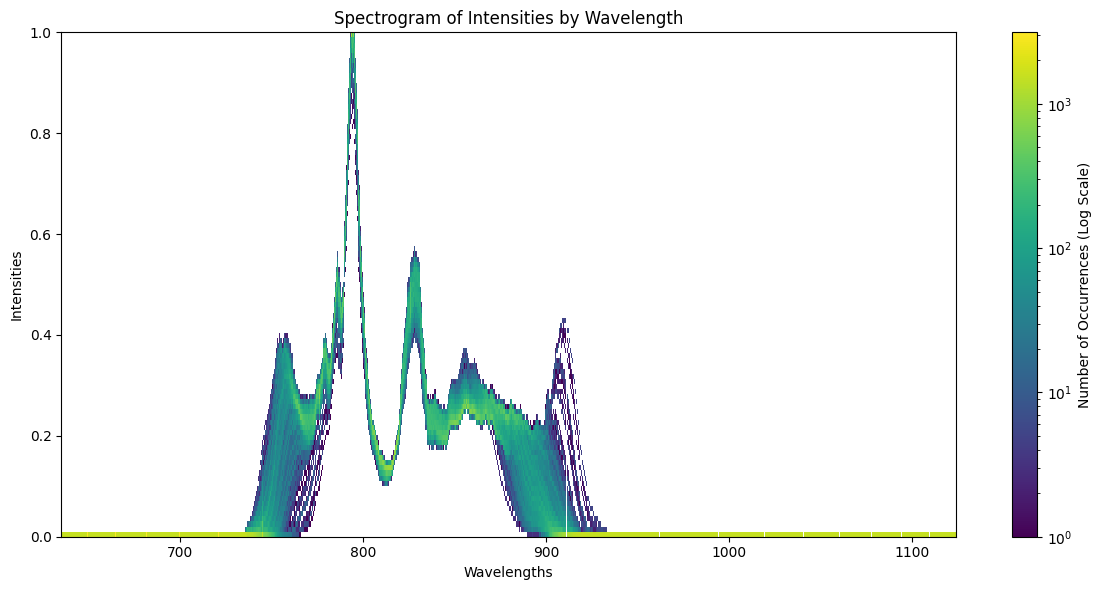

In [13]:
create_spectrogram(wavelengths, x_real, label="Spectrogram of Intensities by Wavelength")